# Importing Libraries

In [1]:
# Importing Libraries
import os, pickle, glob, sys
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

In [2]:
# Initializing SparkSession
sc = SparkSession.builder \
    .config("spark.driver.memory", "10g") \
	.config("spark.executor.memory", "10g") \
    .config('spark.executor.instances', 5) \
	.getOrCreate()
print(sc)

In [3]:
csv_file = "./us_congestion_2016_2022/us_congestion_2016_2022.csv"

In [ ]:
df = sc.read.csv(csv_file, header=True, inferSchema=True)

# Exploring Data

In [5]:
# Inspecting First Row
first_row = df.take(1)[0]
print(first_row)

Row(ID='C-1', Severity=0, Start_Lat=42.410881, Start_Lng=-71.147995, StartTime=datetime.datetime(2020, 11, 10, 14, 54), EndTime=datetime.datetime(2020, 11, 10, 16, 29, 27), Distance(mi)=3.990000009536743, DelayFromTypicalTraffic(mins)=0.0, DelayFromFreeFlowSpeed(mins)=4.0, Congestion_Speed='Moderate', Description='Delays of four minutes and delays increasing on Massachusetts Ave Westbound between MA-2A Massachusetts Ave and US-3 Mass Ave. Average speed 15 mph.', Street='Wyman Ter', City='Arlington', County='Middlesex', State='MA', Country='US', ZipCode='02474-6726', LocalTimeZone='US/Eastern', WeatherStation_AirportCode='KBED', WeatherTimeStamp=datetime.datetime(2020, 11, 10, 14, 51), Temperature(F)=64.0, WindChill(F)=64.0, Humidity(%)=63.0, Pressure(in)=29.93, Visibility(mi)=10.0, WindDir='SSW', WindSpeed(mph)=7.0, Precipitation(in)=0.0, Weather_Event=None, Weather_Conditions='Fair')


In [8]:
# Check the schema
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- StartTime: timestamp (nullable = true)
 |-- EndTime: timestamp (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- DelayFromTypicalTraffic(mins): double (nullable = true)
 |-- DelayFromFreeFlowSpeed(mins): double (nullable = true)
 |-- Congestion_Speed: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ZipCode: string (nullable = true)
 |-- LocalTimeZone: string (nullable = true)
 |-- WeatherStation_AirportCode: string (nullable = true)
 |-- WeatherTimeStamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- WindChill(F): double (nullable = true)
 |-- Humidity(%): double 

In [10]:
def shape(df):
    num_rows = df.count()
    num_cols = len(df.columns)
    return num_rows, num_cols

df_rows, df_cols = shape(df)
print("DataFrame has {} rows and {} columns.".format(df_rows, df_cols))

DataFrame has 33304199 rows and 30 columns.


# Data Cleaning and Filtering

In [11]:
# Handle missing values
df = df.dropna()

# Remove duplicates
df = df.dropDuplicates()

In [12]:
# Filtering Fields
#Filter out specific fields we want to keep
fields_to_keep = ['ID', 'Severity', 'DelayFromFreeFlowSpeed(mins)', 'StartTime', 'Congestion_Speed', 'State', 'Pressure(in)', 'Visibility(mi)', 'WindSpeed(mph)', 'Precipitation(in)', 'Weather_Event']

# 33m to 5m data if I filter out the 5 min or longer for traffic
filtered_df = df.select(*fields_to_keep).where(col("State").isNotNull()).where(col("DelayFromFreeFlowSpeed(mins)") > 5.0)
filtered_df.show()

+--------+--------+----------------------------+-------------------+----------------+-----+------------+--------------+--------------+-----------------+-------------+
|      ID|Severity|DelayFromFreeFlowSpeed(mins)|          StartTime|Congestion_Speed|State|Pressure(in)|Visibility(mi)|WindSpeed(mph)|Precipitation(in)|Weather_Event|
+--------+--------+----------------------------+-------------------+----------------+-----+------------+--------------+--------------+-----------------+-------------+
| C-88197|       2|           5.119999885559082|2018-11-28 21:18:00|        Moderate|   NY|       29.78|          10.0|          15.0|              0.0|         Snow|
| C-89281|       1|           6.269999980926514|2018-11-28 12:01:00|        Moderate|   MI|       29.92|           9.0|          18.4|              0.0|         Snow|
|C-106956|       2|            18.1200008392334|2018-11-28 23:42:00|            Slow|   MN|        29.9|           4.0|           8.1|              0.0|         Snow

In [13]:
# Grouping by State
state_count_df = filtered_df.groupBy("State").count()
state_count_df.show()

+-----+-----+
|State|count|
+-----+-----+
|   AZ| 1224|
|   SC|  679|
|   LA|  361|
|   MN| 7052|
|   NJ|11079|
|   DC|  441|
|   OR| 6069|
|   VA| 3471|
|   RI| 2265|
|   WY| 1866|
|   KY| 2588|
|   NH| 1699|
|   MI|12754|
|   NV| 1255|
|   WI| 2617|
|   ID| 1594|
|   CA| 7106|
|   NE| 2055|
|   CT| 6573|
|   MT| 2858|
+-----+-----+
only showing top 20 rows



In [14]:
# Cleaning 'Congestion_Speed' Column
cleaned_df = filtered_df.withColumn("Congestion_Speed", when(col("Congestion_Speed") == "Slow", 0).when(col("Congestion_Speed") == "Moderate", 1).when(col("Congestion_Speed") == "Fast", 3))
cleaned_df.count()

250488

In [15]:
# Grouping by 'Weather_Event' and Counting
weather_counts = filtered_df.groupBy("Weather_Event").count()
weather_counts.show()
#Thunderstorm, Rain, Fog, Snow, Tornado, Hail

+--------------------+------+
|       Weather_Event| count|
+--------------------+------+
|        Thunderstorm|   133|
|   Fog ;Thunderstorm|    75|
|  Rain ;Thunderstorm|   535|
|  Snow ;Thunderstorm|   195|
|                 Fog|  2807|
|Rain ;Snow ;Thund...|    11|
|Fog ;Snow ;Thunde...|   271|
|          Rain ;Snow|  1034|
|                Snow|148239|
|                Rain| 46503|
|          Snow ;Hail|     3|
|           Fog ;Rain|   813|
|Fog ;Rain ;Thunde...|     5|
|           Fog ;Snow| 49844|
|     Fog ;Rain ;Snow|    17|
|          Rain ;Hail|     2|
|Rain ;Hail ;Thund...|     1|
+--------------------+------+



In [17]:
# 1. Extract columns for the Accident table
accident_df = df.select(
    "ID", "Severity", "Start_Lat", "Start_Lng",
    "StartTime", "EndTime", "Distance(mi)",
    "DelayFromTypicalTraffic(mins)",
    "DelayFromFreeFlowSpeed(mins)", "Description"
)

# 2. Extract columns for the Location table
location_df = df.select(
    "ID", "Street", "City", "County", "State",
    "Country", "ZipCode", "LocalTimeZone"
)

# 3. Extract columns for the Weather table
weather_df = df.select(
    "ID", "WeatherStation_AirportCode", "WeatherTimeStamp",
    "Temperature(F)", "WindChill(F)", "Humidity(%)",
    "Pressure(in)", "Visibility(mi)", "WindDir",
    "WindSpeed(mph)", "Precipitation(in)",
    "Weather_Event", "Weather_Conditions"
)

# Write the normalized DataFrames to separate Parquet files
# Replace "path/to/output_directory" with your desired output directory
accident_df.write.parquet("/expanse/lustre/projects/uci150/egarcia1/accident_table.parquet")
location_df.write.parquet("/expanse/lustre/projects/uci150/egarcia1/location_table.parquet")
weather_df.write.parquet("/expanse/lustre/projects/uci150/egarcia1/weather_table.parquet")

In [ ]:
#pdf = cleaned_df.toPandas()

# Data Visualization

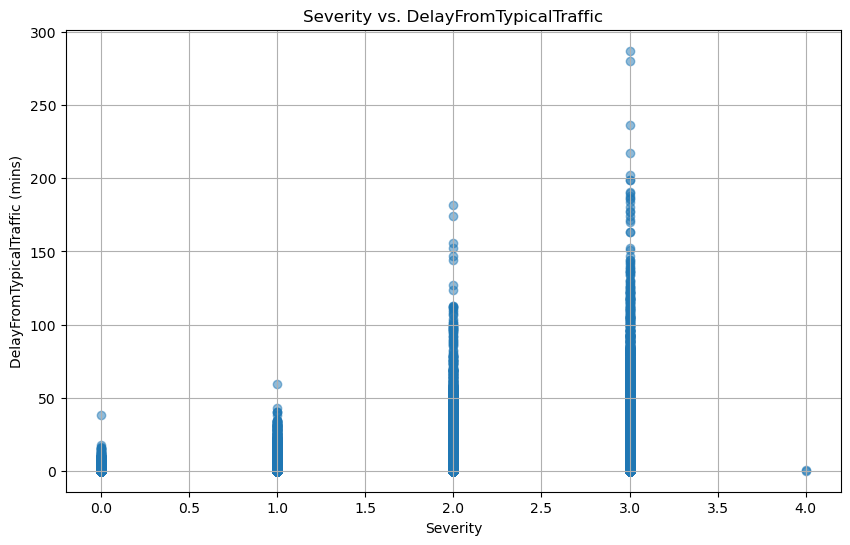

In [19]:
import matplotlib.pyplot as plt

# Read the Parquet file containing the Accident Table
accident_df = sc.read.parquet("/expanse/lustre/projects/uci150/egarcia1/accident_table.parquet")

# Select only Severity and DelayFromTypicalTraffic columns
severity_delay_df = accident_df.select("Severity", "DelayFromTypicalTraffic(mins)")

# Convert DataFrame to Pandas DataFrame
severity_delay_pd = severity_delay_df.toPandas()

# Plot Severity vs. DelayFromTypicalTraffic
plt.figure(figsize=(10, 6))
plt.scatter(severity_delay_pd['Severity'], severity_delay_pd['DelayFromTypicalTraffic(mins)'], alpha=0.5)
plt.title('Severity vs. DelayFromTypicalTraffic')
plt.xlabel('Severity')
plt.ylabel('DelayFromTypicalTraffic (mins)')
plt.grid(True)
plt.show()